# Theory:

Discrete Update equations for RC:
$$
r_{i+1} = (1-\alpha) r_{i} + \alpha\tanh(W_{in} x_i + W r_i)
$$

Continuous Update equations for RC:
$$
\dot{r} = \gamma [-r + \tanh(W_{in}x + W r)] \\
$$

.. with explicit Euler:
$$
r_{i+1} = r_i + dt \gamma [-r_i + \tanh(W_{in}x_i + W r_i)] \\
r_{i+1} = (1-dt\gamma) r_i + dt\gamma\tanh(W_{in}x_i + W r_i)
$$

Time series described by an ODE:

$$
\dot{r} = f(r)
$$

... with explicit Euler:

$$
r_{i+1} = r_i + dt f(r_i)
$$

Two options to couple the ODE with the input:

1. Option: Couple on discrete update level - shift previous point:
$$
r_{i+1} = (W_{in} x_i + r_i) + dt f(W_{in} x_i + r_i)
$$
2. Option: Couple on discrete update level - shift the point only for the force:
$$
r_{i+1} = r_i + dt f(W_{in} x_i + r_i)
$$

3. Option: Couple on ODE level:
$$
\dot{r} = f(r) + W_{in} x \\
r_{i+1} = r_i + dt [f(r_i) + W_{in}x_i]
$$

# Imports:

In [30]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import rescomp

# new imports:
import rescomp.lyapunov_analysis as la

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Lorenz iterator:

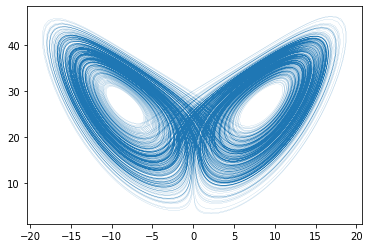

In [31]:
# Lorenz parameters:
dt_L = 0.01
lyap_L = 0.934
starting_point_L = np.array([0, 1, 0])
# starting_point_L = np.array([-14.03020521, -20.88693127, 25.53545])

# lorenz iterator:
def data_creation_function_L(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("lorenz", dt, time_steps, starting_point)

def f_L(x):
    return data_creation_function_L(2, dt_L, x)[-1]

# test lorenz iterator:
disc_steps = 1000
time_steps = 50000

time_series_all = np.zeros((time_steps+disc_steps, 3))
time_series_all[0, :] = starting_point_L

for i in range(1, time_steps+disc_steps):
    x_last = time_series_all[i - 1, :]
    time_series_all[i, :] = f_L(x_last)

time_series_L = time_series_all[disc_steps:, :]

plt.plot(time_series_L[:, 0], time_series_L[:, 2], linewidth=0.1)

# Lorenz 96 Iterator:

Text(0.5, 1.0, 'all')

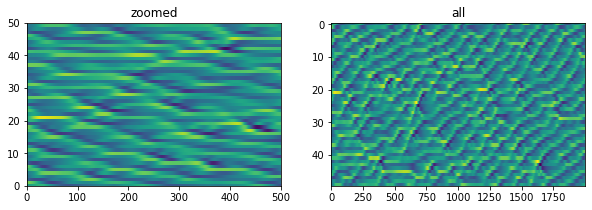

In [450]:
# Lorenz96 parameters:
dt_L96 = 0.01
dims = 50
np.random.seed(1)
starting_point_L96 = np.random.randn(dims)

# Lorenz96 iterator:
_lorenz_96 = rescomp.simulations._lorenz_96
iterator = rescomp.simulations._runge_kutta
f_L96 = lambda x: iterator(_lorenz_96, dt_L96, x)

# test lorenz iterator:
disc_steps = 1000
time_steps = 2000

time_series_all = np.zeros((time_steps+disc_steps, dims))
time_series_all[0, :] = starting_point_L96

for i in range(1, time_steps+disc_steps):
    x_last = time_series_all[i - 1, :]
    time_series_all[i, :] = f_L96(x_last)

time_series_L96 = time_series_all[disc_steps:, :]
starting_point_L96 = time_series_L96[0, :]

# Plot
f = plt.figure(figsize=(10,3))
plt.subplot(121)
plt.imshow(time_series_L96.T, aspect="auto")
plt.xlim(0, 500)
plt.ylim(0, 50)
plt.title("zoomed")

plt.subplot(122)
plt.imshow(time_series_L96.T, aspect="auto")
plt.title("all")

# Coupling Options:

In [512]:
nth = 1
A = np.random.rand(dims, dims)

# Option 1: Iterator based coupling - shift previous point
def act_func_opt1(self, x, r, nth=nth):
    x_add = self._w_in.dot(x)
    for k in range(nth):
        # inp = r + x_add
        inp = np.tanh(r + x_add)
        r = f_L96(inp)
    return r

# Option 2: Iterator based coupling - only shift force
def act_func_opt2(self, x, r, nth=nth):
    x_add = self._w_in.dot(x)
    for k in range(nth):
        inp = r + x_add
        inp = np.tanh(inp)
        r = _lorenz_96(inp)*dt_L96 + r
    return r

# Option 3: ODE based coupling
def act_func_opt3(self, x, r, nth=nth):
    # Coupled ODE:
    _lorenz_96_coupled = lambda r, x_add: _lorenz_96(r) + x_add

    x_add = self._w_in.dot(x)
    for k in range(nth):
        r = _lorenz_96_coupled(r, x_add)*dt_L96 + r
    return r

# Option 4: ODE based coupling with decay
def act_func_opt4(self, x, r, nth=nth):
    # Coupled ODE:
    _lorenz_96_coupled = lambda r, x_add: _lorenz_96(r) + x_add - 7 * r

    x_add = self._w_in.dot(x)
    for k in range(nth):
        r = _lorenz_96_coupled(r, x_add)*dt_L96 + r
    return r

# Option 5: test
def act_func_opt5(self, x, r, nth=nth):
    # Coupled ODE:
    # r = np.tanh(self._w_in.dot(x) + A.dot(r))
    # r = np.tanh(self._w_in.dot(x) + self._network.dot(r))
    r = np.tanh(self._w_in.dot(x) + 0.01*f_L96(r))
    return r

# Option 6: test
def act_func_opt6(self, x, r, nth=nth):
    # Coupled ODE:
    # r = np.tanh(self._w_in.dot(x) + A.dot(r))
    # r = np.tanh(self._w_in.dot(x) + self._network.dot(r))
    r = 0.5*r + 0.5*np.tanh(self._w_in.dot(x) + f_L96(r) - r)
    return r

# Option 7: test
def act_func_opt7(self, x, r, nth=nth):
    # Coupled ODE:
    # r = np.tanh(self._w_in.dot(x) + A.dot(r))
    # r = np.tanh()
    inp = self._w_in.dot(x) + self._network.dot(r)
    r = inp * (inp > 0)
    # r = 0.5*r + 0.5*np.tanh(self._w_in.dot(x) + f_L96(r) - r)
    return r

# Set Custom activation function:

In [523]:
ndim = dims
# custom_act_fct = act_func_opt1
# custom_act_fct = act_func_opt2
# custom_act_fct = act_func_opt3
# custom_act_fct = act_func_opt4
# custom_act_fct = act_func_opt5
custom_act_fct = act_func_opt6
# custom_act_fct = act_func_opt7

# Activation function without coupling:

In [524]:
# will come (problematic for now)

# Create esn architecture:

In [525]:
esn = rescomp.ESNWrapper()
esn.set_console_logger("debug")
w_out = np.random.randn(3, ndim)
# w_out = np.zeros((3, ndim))
esn.create_architecture(ndim, 3, w_out=w_out, seed=11, w_out_fit_flag="simple", leak_fct=0.0, custom_act_fct=custom_act_fct
                        , w_in_scale=0.1, w_in_ordered=True, w_in_sparse=True)
esn.summary()

03-14 10:20:50 [DEBUG  ] Create network
03-14 10:20:50 [DEBUG  ] Create w_in
03-14 10:20:50 [DEBUG  ] Set activation function to flag: tanh_simple
03-14 10:20:50 [DEBUG  ] _w_out_fit_flag set to simple
03-14 10:20:50 [DEBUG  ] Setting self._w_out with the set_w_out function
03-14 10:20:50 [DEBUG  ] ESN can run in loop
INPUT: 
x_dim: 3
INPUT-RESERVOIR COUPLING W_in: 
W_in: (50, 3)
- - - - - - - - - - -
w_in_scale: 0.1, w_in_sparse: True, w_in_ordered: True
RESERVOIR: 
- - - - - - - - - - -
Network: 
n_dim: 50
n_rad: 0.1, n_avg_deg: 6.0, n_type_flag: erdos_renyi, 
- - - - - - - - - - -
Dynamics: 
act_fct_flag: tanh_simple, bias_scale: 0, leak_factor: 0.0
NON-LINEAR TRANSFORM OF RESERVOIR STATE: 
w_out_fit_flag: simple
RESERVOIR-OUTPUT COUPLING W_out: 
W_out: (3, 50)



# Run loop:

(0, 50)

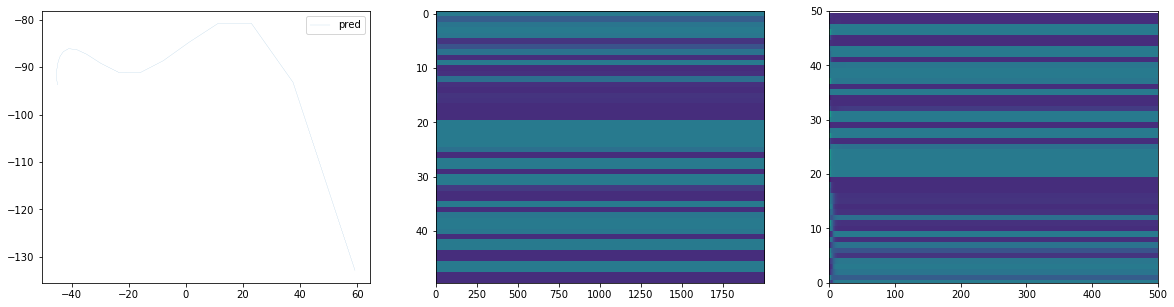

In [533]:
esn.reset_res_state(res_state=starting_point_L96)
y_loop = esn.run_loop(2000, save_r=True)
r = esn._r_pred.copy()
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.plot(y_loop[:, 0], y_loop[:, 2], linewidth=0.1, label="pred")
plt.legend()

plt.subplot(132)
plt.imshow(r.T, aspect="auto")

plt.subplot(133)
plt.imshow(r.T, aspect="auto")
plt.xlim(0, 500)
plt.ylim(0, 50)

# Train:

In [527]:
esn.reset_res_state()
train_steps = 5000
sync_steps = 100
esn.train(x_train=time_series_L[:sync_steps + train_steps], sync_steps=sync_steps, reg_param=0.0001, w_in_no_update=True)
w_out = esn.get_w_out()

03-14 10:20:58 [DEBUG  ] Start syncing the reservoir state
03-14 10:20:59 [DEBUG  ] Start training
03-14 10:20:59 [DEBUG  ] Start syncing the reservoir state
03-14 10:21:04 [DEBUG  ] Fit _w_out according to method 0


# Predict:

In [528]:
time_series_L_pred = time_series_L[sync_steps + train_steps:]
time_series_L_pred.shape

(44900, 3)

In [529]:
predict_sync_steps = 100
predict_steps = 2000
# sync:
esn.reset_res_state()
esn.synchronize(time_series_L_pred[:predict_sync_steps])

# predict:
y_pred, y_test = esn.predict(time_series_L_pred[predict_sync_steps:predict_sync_steps+predict_steps], save_r=True)
r = esn._r_pred.copy()
# w_out_L = esn.get_w_out()
# print(w_out_L.shape)

03-14 10:21:04 [DEBUG  ] Start syncing the reservoir state
03-14 10:21:04 [DEBUG  ] Start Prediction


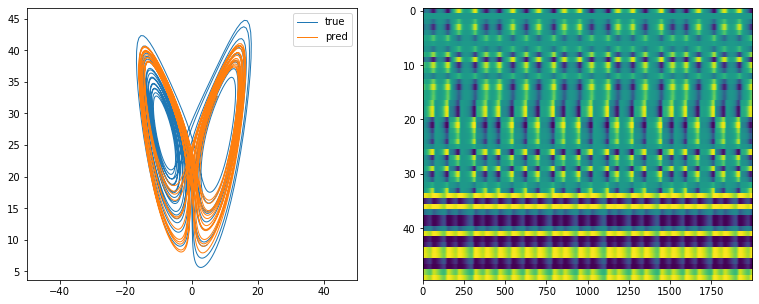

In [530]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.plot(y_test[:, 0], y_test[:, 2], linewidth=1, label="true")
plt.plot(y_pred[:, 0], y_pred[:, 2], linewidth=1, label="pred")

plt.legend()
plt.xlim(-50, 50)

plt.subplot(122)
plt.imshow(r.T, aspect="auto")

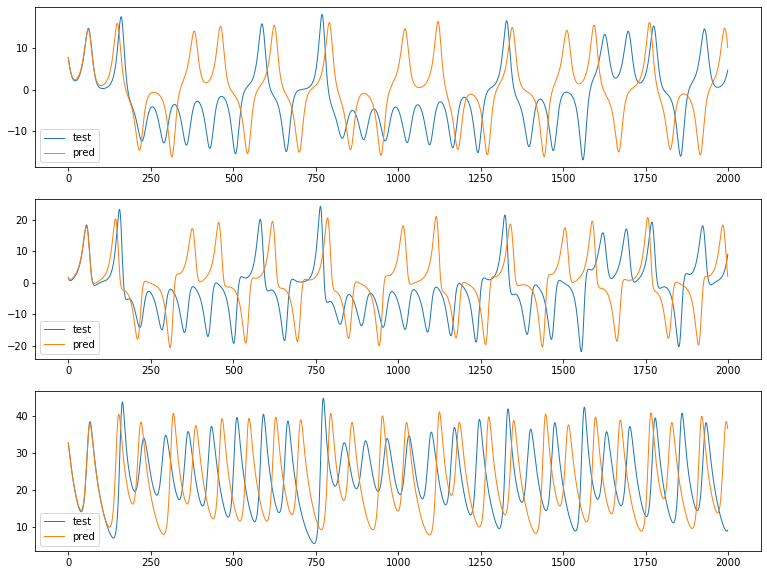

In [531]:
plt.figure(figsize=(13, 10))

for ix in range(3):
    plt.subplot(f"31{ix+1}")
    plt.plot(y_test[:, ix], linewidth=1, label="test")
    plt.plot(y_pred[:, ix], linewidth=1, label="pred")
    plt.legend()